##Predicting Sunspots With Neural Networks 

Use Convolutional, LSTMs, and Dense layers in a model that will be trained on sunspot data.

##Imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

##Plot Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

##Download and Preview the Data

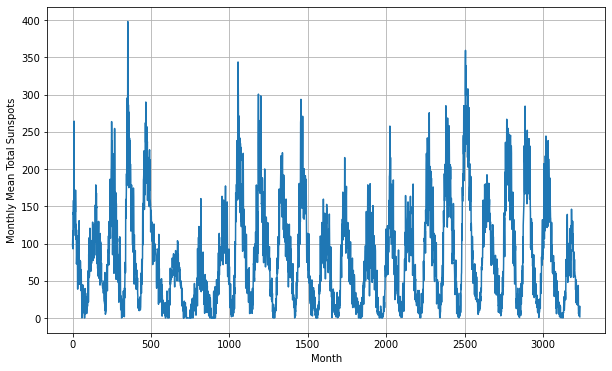

In [ ]:
#Initialize lists 
time_step = []
sunspots = []

#Open CSV File 
with open('./Sunspots.csv') as csvfile:

  #Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  #Skip the first line 
  next(reader)

  #Append row and sunspot number to lists 
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

#Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(sunspots)

#Preview the data 
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspots')

##Split the dataset 

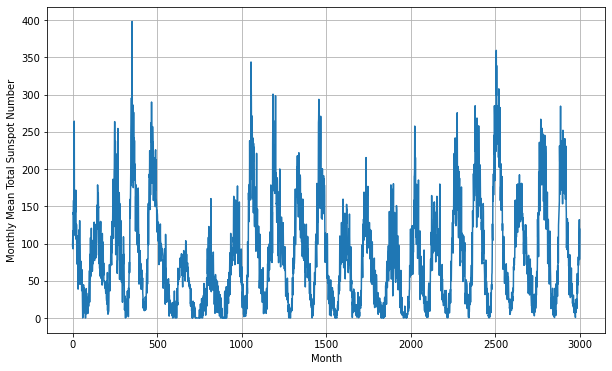

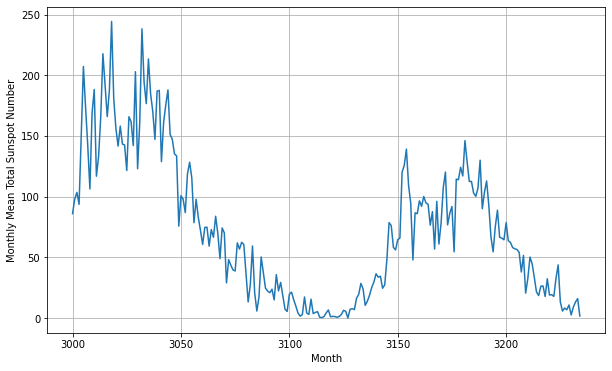

In [ ]:
#Define the split time 
split_time = 3000

#Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

#Get the validation set 
time_valid = time[split_time:]
x_valid = series[split_time:]

plot_series(time_train, x_train, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')
plot_series(time_valid, x_valid, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

##Prep Features and Labels

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows 

  Args:
    series (array of floats) - contain the values of the time series 
    window_size (int) - number of time steps to include in the feature
    batch_size (int) - size of batches that will be fed into the model 
    shuffle_buffer (int) - buffer size for the shuffle method 

  Returns:
    dataset (TF Dataset) - TF Dataset containing time windows 
  """

  #Generate a TF Dataset from the series values 
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #Window the data but only take those with the specified size 
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)

  #Flatten the windows by putting its elements in a single batch 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

  #Create tuples with features and labels 
  dataset = dataset.map(lambda window: (window[: -1], window[-1]))

  #Shuffle the windows 
  dataset = dataset.shuffle(shuffle_buffer)

  #Create batches of windows 
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

##Parameters 

Tweak the parameters to imporve performance

In [ ]:
#Parameters 
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

#Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

##Build the model 

In [ ]:
#Build the model 
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(filters = 64, kernel_size = 3,
                             strides = 1, activation = 'relu',
                             padding = 'causal',
                             input_shape = [window_size, 1]),
      tf.keras.layers.LSTM(64, return_sequences=True),
      tf.keras.layers.LSTM(64),
      tf.keras.layers.Dense(30, activation='relu'),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 400) #Scale output by 400
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

##Tune the learning rate

In [ ]:
#Get the initial weights 
init_weights = model.get_weights()

In [ ]:
#Set the learning rate scheduler 
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

#Initialize the optimizer 
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

#Set the training parameters 
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

#Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 7s 37ms/step - loss: 184.8052 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 3s 36ms/step - loss: 119.1464 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 3s 36ms/step - loss: 69.2563 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 3s 36ms/step - loss: 49.1052 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 3s 36ms/step - loss: 41.4313 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 3s 35ms/step - loss: 38.3757 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 4s 36ms/step - loss: 36.0507 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 4s 37ms/step - loss: 33.8590 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 4s 37ms/step - loss: 32.0577 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 4s 36ms/step - loss: 30.7488 - lr: 2.8184e-08
Epoch 1

In [1]:
#Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

#Set the figure size
plt.figure(figsize = (10,6))

#Set the grid
plt.grid(True)

#Plot the loss in log scale 
plt.semilogx(lrs, history.history['loss'])

#Increase the tickmarks size 
plt.tick_params('both', length=10, width=1, which='both')

#Set the plot boundaries
plt.axis([1e-8, 1e-63, 0, 60])

NameError: ignored

It's a little unstable, but 10^-6 looks like the optimal level

##Train the model 

The model will be trained on 500 epochs and the previous lab will be re-run with the same number of epochs

In [ ]:
#Reset states generated by Keras
tf.keras.backend.clear_session()

#Reset the weights 
model.set_weights(init_weights)

In [ ]:
#Set the learning rate
learning_rate = 8e-6

#Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

#Set the training parameters 
model.compile(loss = tf.keras.losses.Huber(),
              optimizer = optimizer, 
              metrics = ['mae'])

In [ ]:
#Train the model
history = model.fit(train_set, epochs = 500)

Epoch 1/500
93/93 [==============================] - 7s 36ms/step - loss: 30.8042 - mae: 31.2991
Epoch 2/500
93/93 [==============================] - 4s 36ms/step - loss: 22.8924 - mae: 23.3869
Epoch 3/500
93/93 [==============================] - 4s 37ms/step - loss: 23.0541 - mae: 23.5489
Epoch 4/500
93/93 [==============================] - 4s 37ms/step - loss: 20.9063 - mae: 21.3994
Epoch 5/500
93/93 [==============================] - 4s 37ms/step - loss: 20.2232 - mae: 20.7174
Epoch 6/500
93/93 [==============================] - 4s 37ms/step - loss: 20.8421 - mae: 21.3360
Epoch 7/500
93/93 [==============================] - 4s 37ms/step - loss: 19.7061 - mae: 20.2000
Epoch 8/500
93/93 [==============================] - 3s 36ms/step - loss: 19.4754 - mae: 19.9684
Epoch 9/500
93/93 [==============================] - 3s 36ms/step - loss: 18.3777 - mae: 18.8698
Epoch 10/500
93/93 [==============================] - 3s 36ms/step - loss: 20.5983 - mae: 21.0922
Epoch 11/500
93/93 [=========

Visualize the loss and MAE to check if they are still trending down

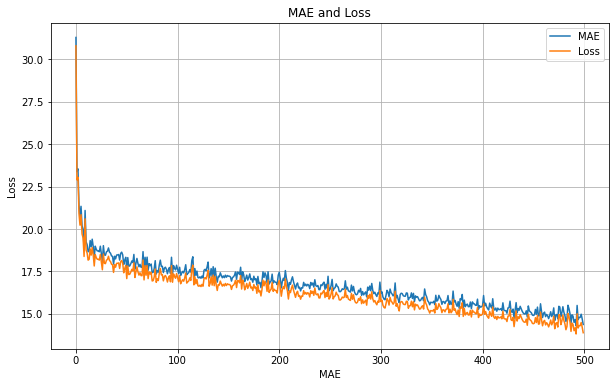

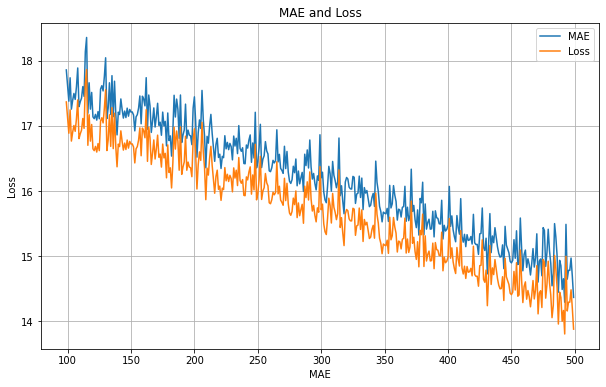

In [ ]:
#Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

#Get number of epochs 
epochs = range(len(loss))

#Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss),
    title='MAE and Loss',
    xlabel = 'MAE',
    ylabel = 'Loss',
    legend = ['MAE', 'Loss']
)

#Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

#Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
)

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

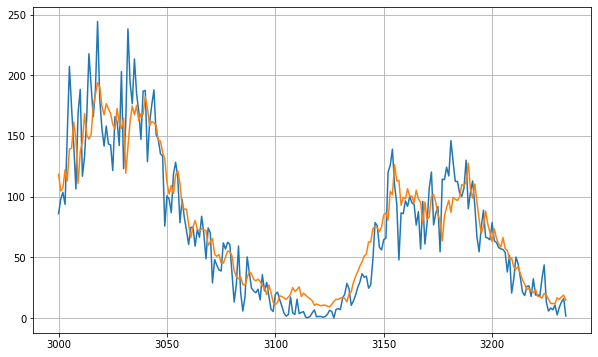

In [ ]:
#Reduce the original series 
forecast_series = series[split_time - window_size: -1]

#Use the helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

#Drop single dimensional axis
results = forecast.squeeze()

#Plot the results
plot_series(time_valid, (x_valid, results))

In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

16.315983
